Keras IMDB sentiment analysis tutorial https://keras.io/examples/nlp/text_classification_with_transformer/

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from keras.utils import to_categorical

In [2]:
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([tf.keras.layers.Dense(ff_dim, activation="relu"), 
                                        tf.keras.layers.Dense(embed_dim),])

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        ffn_output = self.ffn(attn_output)
        return attn_output + ffn_output


In [31]:
class TokenAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.pos_emb = tf.keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim)
        self.token_emb = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions


In [4]:
vocab_size = 20000  # Only consider the top 20k words
maxlen = 200  # Only consider the first 200 words of each movie review
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

In [18]:
(x_train, y_train), (x_val, y_val) = tf.keras.datasets.imdb.load_data(num_words=vocab_size)
print(len(x_train), "Training sequences")
print(len(x_val), "Validation sequences")
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, maxlen)
x_val = tf.keras.preprocessing.sequence.pad_sequences(x_val, maxlen)

# y_train = to_categorical(y_train, 2)
# y_val = to_categorical(y_val, 2)

# import os
# import time
# path_wd = os.path.join('/home/viktor/PycharmProjects/guided_research/snn_toolbox', '..', 'temp', str(time.time()))
# os.makedirs(path_wd)
# # Save dataset so SNN toolbox can find it.
# np.savez_compressed(os.path.join(path_wd, 'x_test'), x_val)
# np.savez_compressed(os.path.join(path_wd, 'y_test'), y_val)
# # SNN toolbox will not do any training, but we save a subset of the training
# # set so the toolbox can use it when normalizing the network parameters.
# np.savez_compressed(os.path.join(path_wd, 'x_norm'), x_train[::10])

25000 Training sequences
25000 Validation sequences


## Tutorial Variant

In [32]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = tf.keras.layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dense(20, activation="relu")(x)
x = tf.keras.layers.Dropout(0.1)(x)
outputs = tf.keras.layers.Dense(2, activation="softmax")(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])
history = model.fit(
    x_train, y_train, batch_size=32, epochs=2, validation_data=(x_val, y_val)
)

Tensor("token_and_position_embedding_8/embedding_16/embedding_lookup/Identity_1:0", shape=(None, 32), dtype=float32)
Tensor("token_and_position_embedding_8/embedding_17/embedding_lookup/Identity_1:0", shape=(None, 200, 32), dtype=float32)
Epoch 1/2
Tensor("model_8/token_and_position_embedding_8/embedding_16/embedding_lookup/Identity_1:0", shape=(None, 32), dtype=float32)
Tensor("model_8/token_and_position_embedding_8/embedding_17/embedding_lookup/Identity_1:0", shape=(None, 200, 32), dtype=float32)
Tensor("model_8/token_and_position_embedding_8/embedding_16/embedding_lookup/Identity_1:0", shape=(None, 32), dtype=float32)
Tensor("model_8/token_and_position_embedding_8/embedding_17/embedding_lookup/Identity_1:0", shape=(None, 200, 32), dtype=float32)
782/782 [==============================] - ETA: 0s - loss: 0.4845 - accuracy: 0.7340Tensor("model_8/token_and_position_embedding_8/embedding_16/embedding_lookup/Identity_1:0", shape=(None, 32), dtype=float32)
Tensor("model_8/token_and_positi

In [33]:
l = model.predict(x_val)

Tensor("model_8/token_and_position_embedding_8/embedding_16/embedding_lookup/Identity_1:0", shape=(None, 32), dtype=float32)
Tensor("model_8/token_and_position_embedding_8/embedding_17/embedding_lookup/Identity_1:0", shape=(None, 200, 32), dtype=float32)


array([0.18443632, 0.81556374], dtype=float32)

In [69]:
class ScaleLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(ScaleLayer, self).__init__()

    def call(self, inputs):
        scale = inputs[1]
        return inputs[0] / scale


class MatMulLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(MatMulLayer, self).__init__()

    def call(self, inputs):
        return tf.matmul(inputs[0], inputs[1])


class MatMulLayerTranspose(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(MatMulLayerTranspose, self).__init__()

    def call(self, inputs):
        return tf.matmul(inputs[0], inputs[1], transpose_b=True)/np.sqrt(inputs[0].shape[-1])


class StandardAdditionLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(StandardAdditionLayer, self).__init__()

    def call(self, inputs):
        return tf.math.add(inputs[0], inputs[1])
    
    
class CreateRangeLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(CreateRangeLayer, self).__init__()

    def call(self, maxlen):
        return tf.range(start=0, limit=maxlen, delta=1)
    

class TokenAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(TokenAndPositionEmbedding, self).__init__()
        self.maxlen = 200
        self.vocab_size = 20000
        self.embed_dim = 32
        self.pos_emb = tf.keras.layers.Embedding(input_dim=self.maxlen, output_dim=self.embed_dim)
        self.token_emb = tf.keras.layers.Embedding(input_dim=self.vocab_size, output_dim=self.embed_dim)

    def call(self, x):
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [ ]:
tf.random.set_seed(1233)
inputs = tf.keras.layers.Input(shape=(maxlen,))
# positions = tf.range(start=0, limit=maxlen, delta=1)
# positions = CreateRangeLayer()(maxlen)
# positions = tf.keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim)(positions)
# x = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)(inputs)
# positions = tf.broadcast_to(positions, (50, 200, 32))
# positions = tf.keras.layers.Reshape([-1, 200, 32])(positions)
# print(positions.shape)
# print(x.shape)
# x = x + positions
# x = StandardAdditionLayer()([x, positions])
# positions = tf.expand_dims(positions, axis=0)
# print(positions.shape)
# x = tf.keras.layers.Add()([x, positions])
x = TokenAndPositionEmbedding()(inputs)
# x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)
# -------------- TRANSFORMER BLOCK -----------------

dv = 25
nv = -1

v2 = tf.keras.layers.Dense(embed_dim, activation="relu")(x)
q2 = tf.keras.layers.Dense(embed_dim, activation="relu")(x)
k2 = tf.keras.layers.Dense(embed_dim, activation="relu")(x)

v = tf.keras.layers.Reshape([embed_dim, nv, dv])(v2)
q = tf.keras.layers.Reshape([embed_dim, nv, dv])(q2)
k = tf.keras.layers.Reshape([embed_dim, nv, dv])(k2)

# softmax(q*k^T/sqrt(dv))
att = MatMulLayerTranspose()([q, k])
att = tf.keras.layers.Softmax(axis=-1)(att)
# softmax(q*k^T/sqrt(dv))*v
out = MatMulLayer()([att, v])

out = tf.keras.layers.Reshape([embed_dim, maxlen, 1])(out)
x = tf.keras.layers.Reshape([embed_dim, maxlen, 1])(x)
add = tf.keras.layers.Add()([out, x])
# add = tf.add(out, x)

x = tf.keras.layers.Dense(embed_dim, activation="relu")(add)
x = tf.keras.layers.Dense(embed_dim)(x)
# --------------------------------------------------
# x = tf.keras.layers.Flatten()(x)
# x = tf.keras.layers.Reshape([1, embed_dim, embed_dim])(x)
x = tf.keras.layers.AveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(20, activation="relu")(x)
x = tf.keras.layers.Dropout(0.1)(x)
outputs = tf.keras.layers.Dense(2, activation="softmax")(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile("adam", "categorical_crossentropy", metrics=["accuracy"])
history = model.fit(x_train, y_train, batch_size=64, epochs=1, validation_data=(x_val, y_val))

In [91]:
class Tokposangles(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(Tokposangles, self).__init__()
        # TODO: remove fixed parametrization
        self.maxlen = 200
        self.vocab_size = 20000
        self.embed_dim = 32
        self.pos_emb = tf.keras.layers.Embedding(input_dim=self.maxlen, output_dim=self.embed_dim, name="positional")
        self.token_emb = tf.keras.layers.Embedding(input_dim=self.vocab_size, output_dim=self.embed_dim, name="token")
        self.positions = self.positional_encoding(self.maxlen, self.embed_dim)
        
    def get_angles(self, pos, i, d_model):
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
        return pos * angle_rates

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(np.arange(position)[:, np.newaxis],
                                     np.arange(d_model)[np.newaxis, :],
                                     d_model)

        # apply sin to even indices in the array; 2i
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

        # apply cos to odd indices in the array; 2i+1
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

        pos_encoding = angle_rads[np.newaxis, ...]

        return tf.cast(pos_encoding, dtype=tf.float32)


    def call(self, x):
        seq_len = tf.shape(x)[1]
#         x = tf.reshape(x, [-1, maxlen, self.embed_dim])
        x = self.token_emb(x)
        x *= tf.math.sqrt(tf.cast(self.embed_dim, tf.float32))
        return x + self.positions[:, :seq_len, :]
    
tf.random.set_seed(123)
inputs = tf.keras.layers.Input(shape=(maxlen,))
# x = Tokposangles()(inputs)
pos = positional_encoding(maxlen, 25)
x = tf.keras.layers.Reshape([200, 25])(inputs)
import pdb;pdb.set_trace()
x = x + pos
# -------------- TRANSFORMER BLOCK -----------------

dv = 25
nv = -1

v2 = tf.keras.layers.Dense(embed_dim, activation="relu")(x)
q2 = tf.keras.layers.Dense(embed_dim, activation="relu")(x)
k2 = tf.keras.layers.Dense(embed_dim, activation="relu")(x)

v = tf.keras.layers.Reshape([embed_dim, nv, dv])(v2)
q = tf.keras.layers.Reshape([embed_dim, nv, dv])(q2)
k = tf.keras.layers.Reshape([embed_dim, nv, dv])(k2)

# softmax(q*k^T/sqrt(dv))
att = MatMulLayerTranspose()([q, k])
att = tf.keras.layers.Softmax(axis=-1)(att)
# softmax(q*k^T/sqrt(dv))*v
out = MatMulLayer()([att, v])

out = tf.keras.layers.Reshape([embed_dim, maxlen, 1])(out)
x = tf.keras.layers.Reshape([embed_dim, maxlen, 1])(x)
add = tf.keras.layers.Add()([out, x])

x = tf.keras.layers.Dense(embed_dim, activation="relu")(add)
x = tf.keras.layers.Dense(embed_dim)(x)
# --------------------------------------------------
x = tf.keras.layers.AveragePooling2D()(x)
# x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(20, activation="relu")(x)
# x = tf.keras.layers.Dropout(0.1)(x)
outputs = tf.keras.layers.Dense(2, activation="softmax")(x)
print(outputs.shape)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile("adam", "categorical_crossentropy", metrics=["accuracy"])
history = model.fit(x_train, y_train, batch_size=64, epochs=5, validation_data=(x_val, y_val))

ValueError: total size of new array must be unchanged, input_shape = [200], output_shape = [200, 25]

In [10]:
model.evaluate(x_val, y_val)

782/782 [==============================] - 20s 25ms/step - loss: 0.3088 - accuracy: 0.8676


[0.30878788232803345, 0.8675600290298462]

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
token_and_position_embedding_1  (None, 200, 32)      646400      input_2[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 200, 32)      1056        token_and_position_embedding_1[0]
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 200, 32)      1056        token_and_position_embedding_1[0]
______________________________________________________________________________________________

In [35]:
import os
from tensorflow import keras
keras.models.save_model(
    model, 
    os.path.join("/home/viktor/PycharmProjects/guided_research/transformer-to-snn-conversion", 
    "mnist_transformer" + '.h5')
)

In [36]:
reconstructed_model = keras.models.load_model(
    os.path.join("/home/viktor/PycharmProjects/guided_research/transformer-to-snn-conversion", 
    "mnist_transformer" + '.h5'), custom_objects={'MatMulLayer': MatMulLayer, 
                                                  'MatMulLayerTranspose': MatMulLayerTranspose,
#                                                   'CreateRangeLayer': CreateRangeLayer,
#                                                   'StandardAdditionLayer': StandardAdditionLayer,
                                                  'TokenAndPositionEmbedding': TokenAndPositionEmbedding})

## One-hot encoding

In [40]:
import numpy as np
from keras.datasets import imdb

# Load the data, keeping only 10,000 of the most frequently occuring words
(train_data, train_labels), (val_data, val_labels) = imdb.load_data(num_words = 5000)

def vectorize_sequences(sequences, dimension=5000):
    results = np.zeros((len(sequences), dimension))    # Creates an all zero matrix of shape (len(sequences),10K)
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1                        # Sets specific indices of results[i] to 1s
    return results

# Vectorize training Data
x_train = vectorize_sequences(train_data)
# Vectorize testing Data
x_val = vectorize_sequences(val_data)

y_train = np.asarray(train_labels).astype('float32')
y_val  = np.asarray(val_labels).astype('float32')

y_train = to_categorical(y_train, 2)
y_val = to_categorical(y_val, 2)

# import os
# import time
# path_wd = os.path.join('/home/viktor/PycharmProjects/guided_research/snn_toolbox', '..', 'temp', str(time.time()))
# os.makedirs(path_wd)
# # Save dataset so SNN toolbox can find it.
# np.savez_compressed(os.path.join(path_wd, 'x_test'), x_val)
# np.savez_compressed(os.path.join(path_wd, 'y_test'), y_val)
# # SNN toolbox will not do any training, but we save a subset of the training
# # set so the toolbox can use it when normalizing the network parameters.
# np.savez_compressed(os.path.join(path_wd, 'x_norm'), x_train[::10])

In [34]:
class Tokposangles(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(Tokposangles, self).__init__()
        # TODO: remove fixed parametrization
        self.maxlen = 200
        self.vocab_size = 20000
        self.embed_dim = 32
        # self.pos_emb = tf.keras.layers.Embedding(input_dim=self.maxlen, output_dim=self.embed_dim, name="positional")
        self.token_emb = tf.keras.layers.Embedding(input_dim=self.vocab_size, output_dim=self.embed_dim, name="token")
        self.positions = self.positional_encoding(self.maxlen, self.embed_dim)

    def get_angles(self, pos, i, d_model):
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
        return pos * angle_rates

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(np.arange(position)[:, np.newaxis],
                                     np.arange(d_model)[np.newaxis, :],
                                     d_model)

        # apply sin to even indices in the array; 2i
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

        # apply cos to odd indices in the array; 2i+1
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

        pos_encoding = angle_rads[np.newaxis, ...]

        return tf.cast(pos_encoding, dtype=tf.float32)

    def call(self, x):
        seq_len = tf.shape(x)[1]
        x = self.token_emb(x)
        x *= tf.math.sqrt(tf.cast(self.embed_dim, tf.float32))
        return x + self.positions[:, :seq_len, :]

def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                                 np.arange(d_model)[np.newaxis, :],
                                 d_model)

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

In [44]:
(x_train, y_train), (x_val, y_val) = tf.keras.datasets.imdb.load_data(num_words=20000)
print(len(x_train), "Training sequences")
print(len(x_val), "Validation sequences")
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, 200)
x_val = tf.keras.preprocessing.sequence.pad_sequences(x_val, 200)

y_train = to_categorical(y_train, 2)
y_val = to_categorical(y_val, 2)


25000 Training sequences
25000 Validation sequences


In [50]:
inputs = tf.keras.layers.Input(shape=(200,))
# x = tf.keras.layers.Embedding(input_dim=20000, output_dim=32, name="token")(inputs)
# pos = positional_encoding(200, 25)
# x = tf.keras.layers.Reshape([200, 25])(inputs)
# x = x + pos
x = tf.keras.layers.Dense(200, activation='relu')(inputs)
x = tf.keras.layers.Dense(64, activation='relu')(x)
# x = tf.keras.layers.Reshape([4, 2, 8])(x)
# x = tf.expand_dims(x, axis=1)
# x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Flatten()(x)
# print(x.shape)
# x = tf.squeeze(x, axis=1)
x = tf.keras.layers.Dense(2, activation='softmax')(x)
model = tf.keras.Model(inputs=inputs, outputs=x)

In [51]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [52]:
history = model.fit(x_train,
                   y_train,
                   epochs=20,
                   batch_size=128,
                   validation_data=(x_val, y_val))

Epoch 1/20
196/196 [==============================] - 1s 2ms/step - loss: 299.5150 - accuracy: 0.5000 - val_loss: 44.2433 - val_accuracy: 0.4997
Epoch 2/20
196/196 [==============================] - 0s 1ms/step - loss: 26.3840 - accuracy: 0.5399 - val_loss: 8.9008 - val_accuracy: 0.5043
Epoch 3/20
196/196 [==============================] - 0s 1ms/step - loss: 6.0700 - accuracy: 0.5413 - val_loss: 4.0968 - val_accuracy: 0.5005
Epoch 4/20
196/196 [==============================] - 0s 1ms/step - loss: 3.1542 - accuracy: 0.5461 - val_loss: 3.0592 - val_accuracy: 0.5005
Epoch 5/20
196/196 [==============================] - 0s 1ms/step - loss: 2.1334 - accuracy: 0.5471 - val_loss: 4.0115 - val_accuracy: 0.5017
Epoch 6/20
196/196 [==============================] - 0s 1ms/step - loss: 1.9434 - accuracy: 0.5472 - val_loss: 3.1104 - val_accuracy: 0.5015
Epoch 7/20
196/196 [==============================] - 0s 1ms/step - loss: 1.8843 - accuracy: 0.5425 - val_loss: 2.1375 - val_accuracy: 0.5034
Ep

(1, 200, 16)


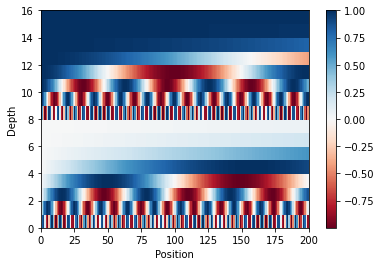

In [60]:
import matplotlib.pyplot as plt
n = 200
d = 16
pos_encoding = positional_encoding(n, d)
print(pos_encoding.shape)
pos_encoding = pos_encoding[0]

# Juggle the dimensions for the plot
pos_encoding = tf.reshape(pos_encoding, (n, d//2, 2))
pos_encoding = tf.transpose(pos_encoding, (2,1,0))
pos_encoding = tf.reshape(pos_encoding, (d, n))

plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()


In [12]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 5000)]            0         
_________________________________________________________________
dense_8 (Dense)              (None, 16)                80016     
_________________________________________________________________
dense_9 (Dense)              (None, 64)                1088      
_________________________________________________________________
tf.reshape_1 (TFOpLambda)    (None, 4, 2, 8)           0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 8)                 0         
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 18        
Total params: 81,122
Trainable params: 81,122
Non-trainable params: 0
_______________________________________________________

## Pre trained Embedding

In [26]:
import os, shutil
import numpy as np

# path to the directory where the original dataset was uncompressed
imdb_dir = 'aclImdb'

In [27]:
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
  dir_name = os.path.join(train_dir, label_type)

  for fname in os.listdir(dir_name):
    if fname[-4:] == '.txt':
      f = open(os.path.join(dir_name, fname))
      texts.append(f.read())
      f.close()

      if label_type == 'neg':
          labels.append(0)
      else:
          labels.append(1)

In [29]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np
from tensorflow.keras.utils import to_categorical

maxlen = 200 # cuts off reviews after 100 words
training_samples = 20000 # trains on 200 samples
validation_samples = 5000
max_words = 10000 # considers only the top 10,000 words in the dataset

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]
y_train = to_categorical(y_train, 10)
y_val = to_categorical(y_val, 10)

Found 88582 unique tokens.
Shape of data tensor: (25000, 200)
Shape of label tensor: (25000,)


In [18]:
x_train.shape

(20000, 200)

In [30]:
embeddings_index = {}
f = open('glove/glove.6B.100d.txt')

for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs

f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [31]:
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))

for word, i in word_index.items():
  if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

In [44]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.038194  , -0.24487001,  0.72812003, ..., -0.1459    ,
         0.82779998,  0.27061999],
       [-0.071953  ,  0.23127   ,  0.023731  , ..., -0.71894997,
         0.86894   ,  0.19539   ],
       ...,
       [-0.25373   , -0.88200998, -0.068905  , ..., -0.092328  ,
         0.026667  , -0.17737   ],
       [-0.7888    ,  0.97996002, -0.019584  , ..., -0.047364  ,
         0.51482999, -0.39811999],
       [ 0.40972999,  0.39761999,  0.75586998, ...,  0.21242   ,
         0.25915   ,  0.87817001]])

In [60]:
embedding_layer = Embedding(max_words,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_words,
                            trainable=False)

In [50]:
len(word_index)

88582

In [52]:
embedding_layer.get_weights()

[]

In [64]:
from keras.layers import Embedding, Flatten, Dense, Input
from keras.models import Sequential
import tensorflow as tf

inputs = Input(shape=(maxlen,))

embedding_layer = Embedding(max_words,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_words,
                            trainable=False)(inputs)
# x = Embedding(input_dim=max_words, output_dim=embedding_dim, trainable=False)(inputs)
x = Flatten()(embedding_layer)
x = Dense(250, activation='relu')(x)
outputs = Dense(10, activation="softmax")(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
               metrics=['acc'])

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_data=(x_val, y_val))

Epoch 1/10
157/157 [==============================] - 4s 25ms/step - loss: 2.6346 - acc: 0.4872 - val_loss: 1.2442 - val_acc: 0.4992
Epoch 2/10
157/157 [==============================] - 4s 25ms/step - loss: 0.7517 - acc: 0.6528 - val_loss: 1.2002 - val_acc: 0.5086
Epoch 3/10
157/157 [==============================] - 4s 25ms/step - loss: 0.5805 - acc: 0.7223 - val_loss: 1.3185 - val_acc: 0.4986
Epoch 4/10
157/157 [==============================] - 4s 25ms/step - loss: 0.5056 - acc: 0.7572 - val_loss: 1.2357 - val_acc: 0.4890
Epoch 5/10
157/157 [==============================] - 4s 25ms/step - loss: 0.4497 - acc: 0.7855 - val_loss: 1.2676 - val_acc: 0.4980
Epoch 6/10
157/157 [==============================] - 4s 25ms/step - loss: 0.4028 - acc: 0.8153 - val_loss: 1.3342 - val_acc: 0.4954
Epoch 7/10
157/157 [==============================] - 4s 26ms/step - loss: 0.4148 - acc: 0.8052 - val_loss: 1.3554 - val_acc: 0.4974
Epoch 8/10
157/157 [==============================] - 4s 27ms/step - 